In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
import geoplot as gplt
import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_8"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
# dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
# dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

evaluation_amount = {"UK25":3000,"UK50":5000,"UK75":10000}

In [3]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = evaluation_amount[dataset[:-2]]
observer_update_interval = 60
logpath = "parameter_data/reruns2/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error)
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            


[Errno 17] File exists: 'parameter_data/reruns2/UK25_8'


In [13]:
logpath

'parameter_data/reruns2/UK25_8'

In [4]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# NSGA-II

In [5]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])




Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30} 
IGD:260.31425240587635
Best fitness: 105.2231 --- 238.1                        
Best total fuel consumption:105.22 
Computing time: 2.72s                        
Average computing speed: 1101.18it/s
Current Route:[['V0', 11, 9, 19, 25, 21, 20], ['V1', 8, 14, 16, 12, 2], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


In [36]:
nsga2_log_data = pd.DataFrame(plot_data_NSGAII)
nsga2_log_data.to_csv("{}/NSGA2.csv".format(logpath))

# NSGA-III

In [6]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII = VRP(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])



nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:257.970069163303
Best fitness: 102.9407 --- 238.1                        
Best total fuel consumption:102.94 
Computing time: 2.92s                        
Average computing speed: 1027.01it/s
Current Route:[['V0', 16, 11, 9, 12, 25, 21, 20], ['V1', 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


In [11]:
get_solution_results(front_NSGAIII[0],routingContext,vehicles)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,129.339,02:47:56,3518.0,21.077814,16.296565,46.210838
1,307.340,05:18:07,2332.0,49.078553,15.968814,57.967412
2,97.631,02:25:19,1100.0,16.084077,16.474354,40.310999
3,82.350,02:48:29,1187.0,13.816167,16.777373,29.326343
4,186.006,03:25:55,3136.0,32.571812,17.511162,54.198430
5,155.468,03:16:25,4143.0,26.961482,17.342143,47.491286
6,123.652,02:09:34,812.0,17.977043,14.538417,57.261024
7,173.174,03:29:48,3258.0,26.808660,15.480765,49.525453
8,79.013,01:57:20,701.0,12.763862,16.154129,40.404375


In [14]:
nsga3_log_data = pd.DataFrame(plot_data_NSGAIII)
nsga3_log_data.to_csv("{}/NSGA3.csv".format(logpath))

# UNSGA-III

In [7]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_UNSGAIII = VRP(data_model_input_multi_objective)
    problem_UNSGAIII.name = "UNSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)

    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])

     
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20} 
IGD:260.52250871321286
Best fitness: 105.7373 --- 238.1                        
Best total fuel consumption:105.74 
Computing time: 2.88s                        
Average computing speed: 1040.3it/s
Current Route:[['V0', 11, 9, 12, 19, 25, 21, 20], ['V1', 8, 14, 16, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


In [38]:
unsga3_log_data = pd.DataFrame(plot_data_UNSGAIII)
unsga3_log_data.to_csv("{}/UNSGA3.csv".format(logpath))

# IBEA

In [8]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_IBEA = VRP(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])

ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20} 
IGD:260.52250871321286
Best fitness: 105.7373 --- 238.1                        
Best total fuel consumption:105.74 
Computing time: 3.85s                        
Average computing speed: 779.75it/s
Current Route:[['V0', 11, 9, 12, 19, 25, 21, 20], ['V1', 8, 14, 16, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


In [39]:
ibea_log_data = pd.DataFrame(plot_data_IBEA)
ibea_log_data.to_csv("{}/IBEA.csv".format(logpath))

In [9]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameters_GA = optimal_parameters["GA"]



plot_data_GA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_GA = VRP(data_model_input_single_objective)
    problem_GA.name = "GA"
    problem_GA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=parameters_GA["population_size"],
                    offspring_population_size=parameters_GA["population_size"],
                    mutation=PermutationSwapMutation(parameters_GA["mutation"]),
                    crossover=PMXCrossover(parameters_GA["crossover"]),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_GA])
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()


    store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
    

Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 30}
IGD:847.8887958038769
Best fitness: 341.0407                          
Best total fuel consumption:102.94 
Best total drive time:841.62                          
Computing time: 2.43s
Average computing speed: 1233.96it/s                          
Current Route:[['V0', 16, 11, 9, 12, 25, 21, 20], ['V1', 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []
Violation:0
Vehicle Amount:5


In [34]:
nsga2_log_data = pd.DataFrame(plot_data_GA)
nsga2_log_data.to_csv("{}/GA.csv".format(logpath))

<ipython-input-10-e3e5ad24e8af>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

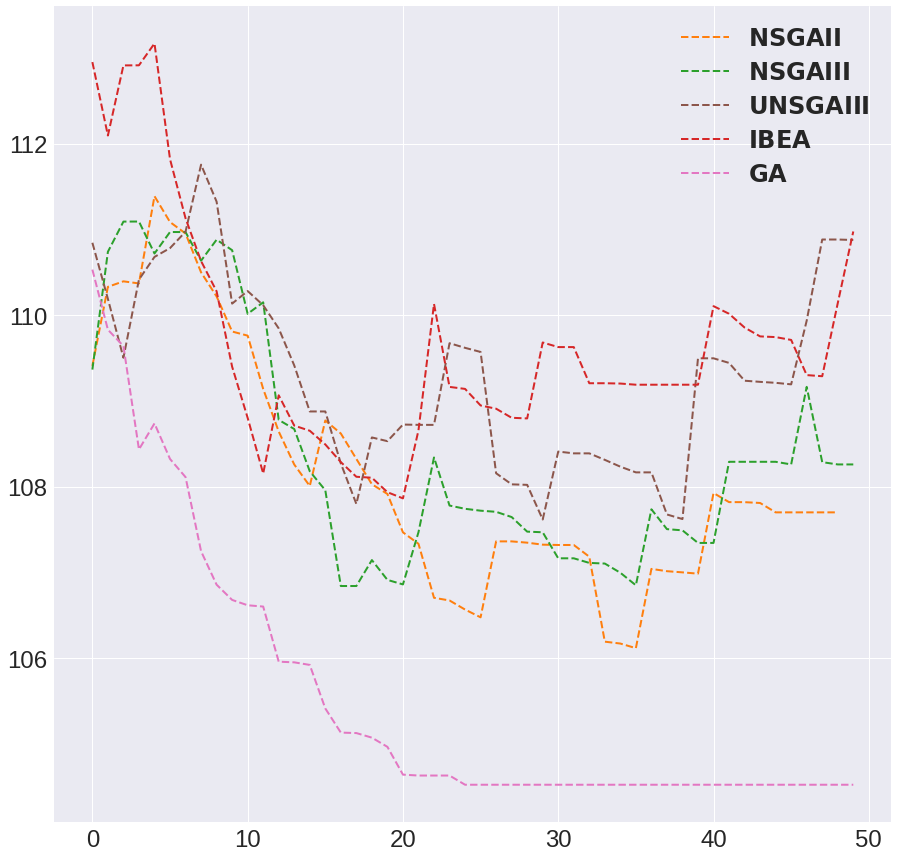

In [10]:
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)[:-1]
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
ga_curve = np.mean(plot_data_GA["fuel_consumption"],axis=0)
curves = np.array([nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve,ga_curve])
lables =np.array(["NSGAII","NSGAIII","UNSGAIII","IBEA","GA"])

plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

<ipython-input-11-1d8db0335a78>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

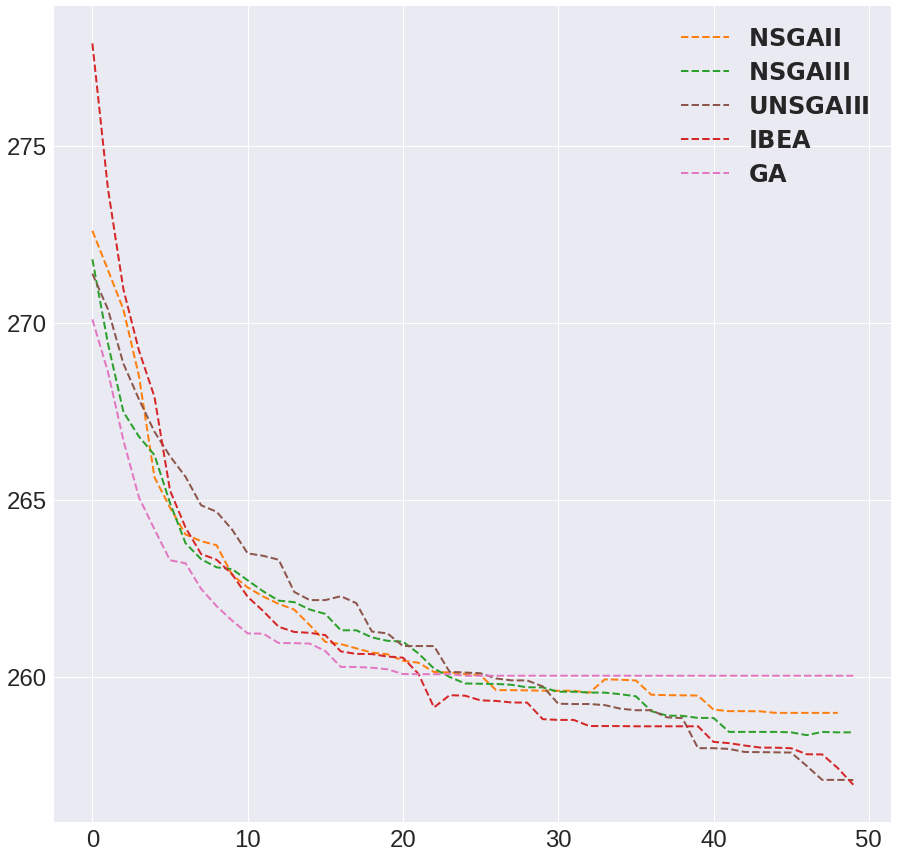

In [11]:
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)[:-1]
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
ga_curve = np.mean(plot_data_GA["distance_to_origin"],axis=0)
curves = np.array([nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve,ga_curve])

lables =["NSGAII","NSGAIII","UNSGAIII","IBEA","GA"]



plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

<ipython-input-12-9e020784bf92>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

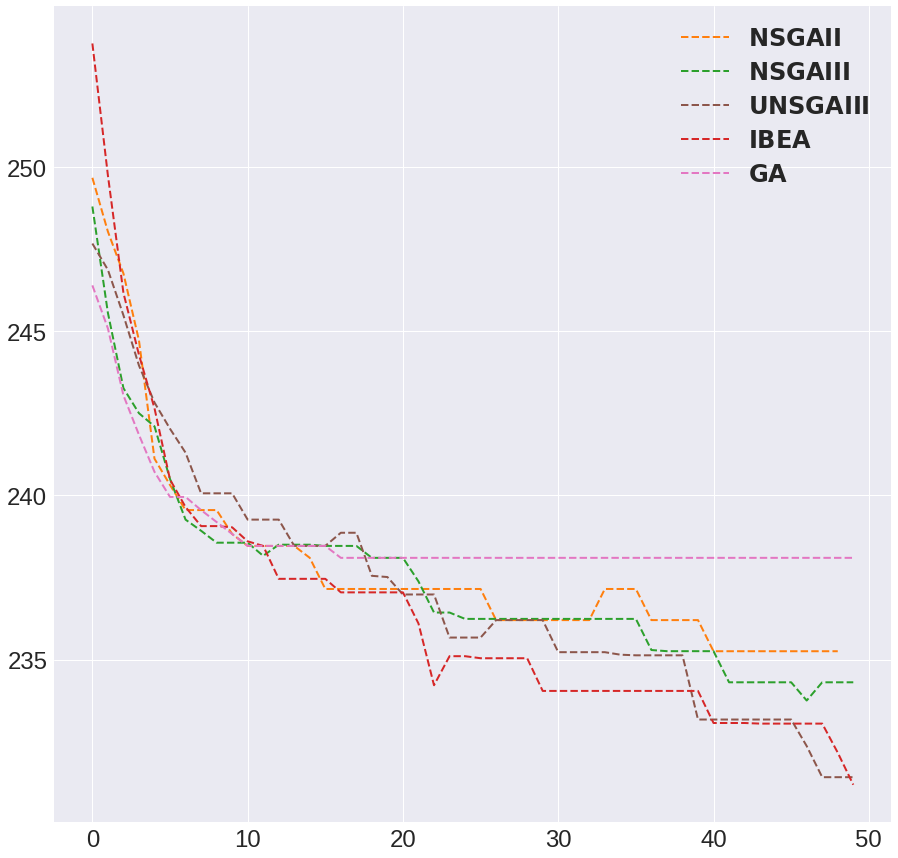

In [12]:
nsga2_curve = np.mean(np.array(plot_data_NSGAII["fitness"]),axis=0)[:,1][:-1]
nsga3_curve = np.mean(np.array(plot_data_NSGAIII["fitness"]),axis=0)[:,1]
unsga3_curve = np.mean(np.array(plot_data_UNSGAIII["fitness"]),axis=0)[:,1]
ibea_curve = np.mean(np.array(plot_data_IBEA["fitness"]),axis=0)[:,1]
ga_curve = np.mean(np.array(plot_data_GA["fitness"]) - np.array(plot_data_GA["fuel_consumption"]),axis=0)
curves = np.array([nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve,ga_curve])

lables =["NSGAII","NSGAIII","UNSGAIII","IBEA","GA"]



plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

In [24]:
np.array(plot_data_NSGAIII["fitness"])

array([[106.20291153, 250.11666667],
       [109.31696043, 249.01666667],
       [116.74592821, 238.1       ],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [109.21867389, 249.01666667],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [106.30119807, 250.11666667],
       [109.37661616, 250.11666667],
       [124.6027577 , 238.1       ],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [123.10745714, 238.1       ],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [109.37661616, 250.11666667],
       [116.74592821, 238.1       ],
       [109.37661616, 250.11666667],
       [109.21867389, 249.01666667],
       [122.39243727, 239.93333333],
       [109.37661616, 250.11666667],
       [119.9337525 , 238.1       ],
       [109.37661616, 250.11666667],
       [123.10745714, 238.1       ],
       [110.53579758, 238.1       ],
 

In [14]:
pd.DataFrame(plot_data_NSGAII)

,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,distance_to_origin
0,"[[109.37661616447124, 250.11666666666667], [10...","[186849, 327361, 35912, 73898]","[109.37661616447124, 109.37661616447124, 110.5...","[[0.0, 626.0, 300.0, 606.0, 404.0, 746.0, 464....","[0.04976201057434082, 0.10389232635498047, 0.1...","[14191, 21460, 3219, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V1, 11, 9, 12, 19, 25, 21, 20], [V0, 8, 14, ...","[272.9864302635472, 272.9864302635472, 262.506..."
1,"[[109.37661616447124, 250.11666666666667], [10...","[186460, 321487, 35912, 73898]","[109.37661616447124, 109.21867388838294, 123.1...","[[0.0, 166.0, 626.0, 300.0, 606.0, 404.0, 746....","[0.047006845474243164, 0.10914397239685059, 0....","[14941, 20713, 3219, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 16, 11, 9, 12, 19, 25, 21, 20], [V1, 14,...","[272.9864302635472, 271.9154629728047, 268.043..."
2,"[[109.37661616447124, 250.11666666666667], [10...","[186849, 162646, 240552, 73898]","[109.37661616447124, 109.37661616447124, 110.5...","[[0.0, 626.0, 300.0, 606.0, 404.0, 746.0, 464....","[0.04524827003479004, 0.09994697570800781, 0.1...","[14191, 11171, 15448, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 11, 9, 12, 19, 25, 21, 20], [V1, 8, 14, ...","[272.9864302635472, 272.9864302635472, 262.506..."
3,"[[109.37661616447124, 250.11666666666667], [10...","[168240, 159106, 240552, 73898]","[109.37661616447124, 109.37661616447124, 109.3...","[[0.0, 166.0, 626.0, 300.0, 606.0, 746.0, 464....","[0.05147385597229004, 0.10715627670288086, 0.1...","[13329, 11235, 15448, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 16, 11, 9, 12, 25, 21, 20], [V1, 14, 8, ...","[272.9864302635472, 272.9864302635472, 272.986..."
4,"[[109.37661616447124, 250.11666666666667], [10...","[186849, 162646, 181026, 229663, 73898]","[109.37661616447124, 109.37661616447124, 109.3...","[[0.0, 626.0, 300.0, 606.0, 404.0, 746.0, 464....","[0.04738020896911621, 0.1065523624420166, 0.15...","[14191, 11171, 9367, 14163, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 11, 9, 12, 19, 25, 21, 20], [V1, 8, 14, ...","[272.9864302635472, 272.9864302635472, 272.986..."
5,"[[109.37661616447124, 250.11666666666667], [10...","[168629, 167107, 211291, 200427, 73898]","[109.37661616447124, 109.37661616447124, 110.5...","[[0.0, 626.0, 300.0, 606.0, 746.0, 464.0], [0....","[0.0483245849609375, 0.10285258293151855, 0.16...","[12579, 12341, 11625, 11806, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 11, 9, 12, 25, 21, 20], [V1, 16, 14, 8, ...","[272.9864302635472, 272.9864302635472, 262.506..."
6,"[[109.37661616447124, 250.11666666666667], [10...","[168240, 159106, 240552, 73898]","[109.37661616447124, 109.37661616447124, 109.3...","[[0.0, 166.0, 626.0, 300.0, 606.0, 746.0, 464....","[0.04929018020629883, 0.1159062385559082, 0.16...","[13329, 11235, 15448, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 16, 11, 9, 12, 25, 21, 20], [V1, 14, 8, ...","[272.9864302635472, 272.9864302635472, 272.986..."
7,"[[109.37661616447124, 250.11666666666667], [12...","[173605, 204080, 196509, 213581, 73898]","[109.37661616447124, 122.39243727350868, 122.3...","[[0.0, 166.0, 300.0, 606.0, 404.0, 746.0, 464....","[0.04530620574951172, 0.10619664192199707, 0.1...","[13930, 12553, 10561, 12693, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V1, 16, 9, 12, 19, 25, 21, 20], [V0, 8, 14, ...","[272.9864302635472, 269.34719814060475, 269.34..."
8,"[[109.37661616447124, 250.11666666666667], [11...","[186849, 162646, 240552, 73898]","[109.37661616447124, 116.7459282108079, 116.74...","[[0.0, 626.0, 300.0, 606.0, 404.0, 746.0, 464....","[0.0531919002532959, 0.10858535766601562, 0.16...","[14191, 11171, 15448, 8428]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[V0, 11, 9, 12, 19, 25, 21, 20], [V1, 8, 14, ...","[272.986430263

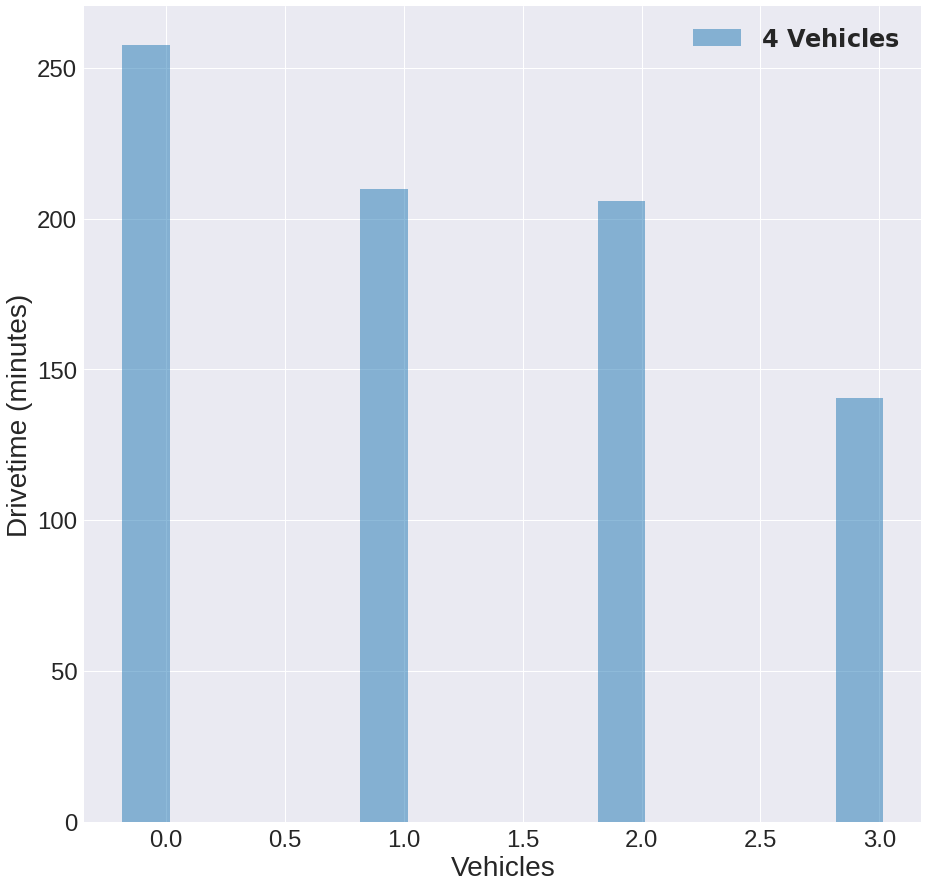

In [28]:
ibea_df = pd.DataFrame(plot_data_IBEA)
ibea_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ibea_df.iterrows()]
routes = ibea_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ibea_df["Parameter Group"] = 1
ibea_best = ibea_df.head(1)
plot_vehicle_drivetimes(ibea_best,1)

In [29]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(ibea_best.paths[0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


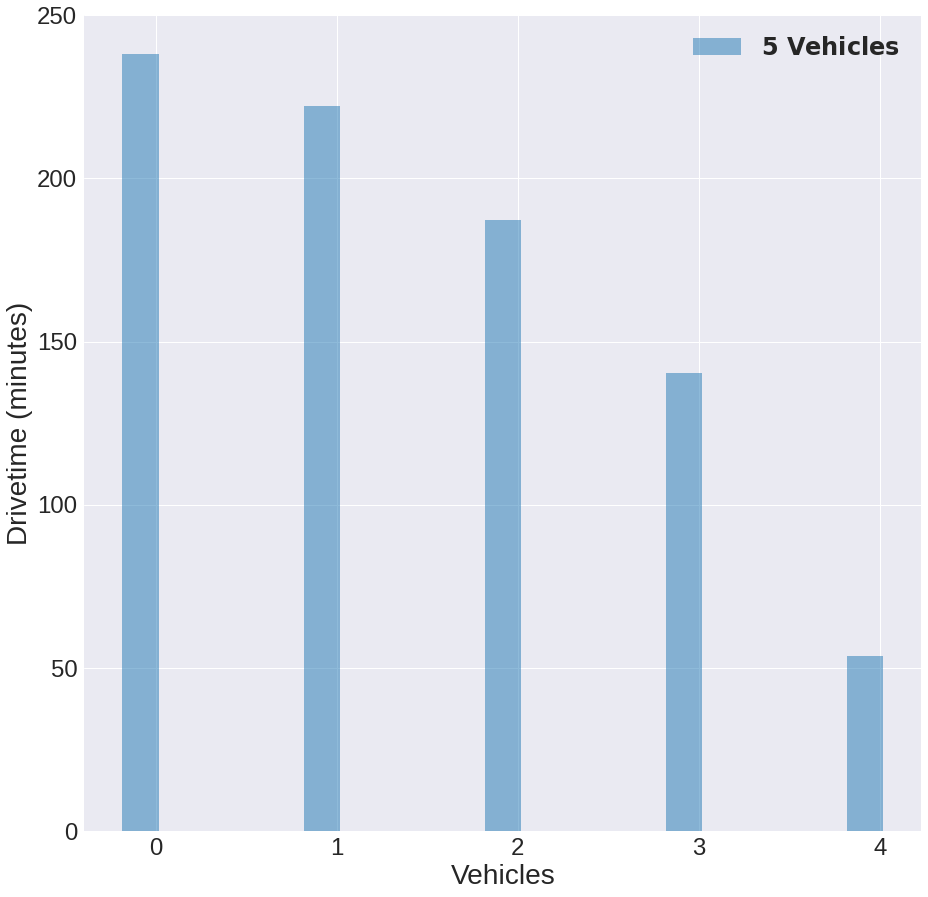

In [26]:
ga_df = pd.DataFrame(plot_data_GA)
ga_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ga_df.iterrows()]
routes = ga_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ga_df["Parameter Group"] = 1
ga_best = ga_df.head(1)
plot_vehicle_drivetimes(ga_best,1)

In [27]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(ga_best.paths[0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
